#  Random Forest from scratch

## Data preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

# Step 1: Load the California Housing dataset from the downloaded CSV file
housing = fetch_california_housing()
# Convert the features to a DataFrame
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['Target'] = housing.target


### understanding and handling the dataset

In [3]:
# Check for missing values
print(housing_df.isnull().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64


In [4]:
# get tenth of the sample
n_samples = housing_df.shape[0] // 10
n_samples_subset = n_samples // 10

# Remove 'Population' from the features
features = housing_df.drop(['Target', 'Population'], axis=1)
X_small_drop_population = features.values[:n_samples]

X_small = housing_df.drop('Target', axis=1).values[:n_samples]
y_small = housing_df['Target'].values[:n_samples]  # Select first half of the samples for target

X_small.shape, y_small.shape  # Show the shapes of X_half and y_half


((2064, 8), (2064,))

### Alternative treatment of data: 'Population" feature as sample weight (*** not used for demostration)

In [8]:
# Extract 'Population' as sample weights
sample_weights = housing_df['Population'].values[:n_samples]

# Normalize the sample weights
sample_weights = sample_weights / np.sum(sample_weights)


# Extract 'Population' as sample weights for the subset and normalize
sample_weights_small = housing_df['Population'].values[:n_samples_subset]
sample_weights_small = sample_weights_small / np.sum(sample_weights_small)


# Random Forest
## loss function:  MSE or MAE
## Hyperparameters:
### n_trees
### max_depth
### min_samples_split
### min_samples_leaf
### min_weight_fraction_leaf
### max_features
### bootstrap



In [5]:
# Step 2: Implement Random Forest from Scratch


def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] < threshold
    right_mask = X[:, feature_index] >= threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]


# best_split() that illustrate the logic of the function clearly, but with slower calculation
def best_split_slow(X, y, features, min_samples_leaf, min_weight_fraction_leaf, n_samples, criterion='mse'):
    best_score = float('inf')
    best_feature = None
    best_threshold = None
    best_impurity_decrease = None  # Initialize impurity decrease

    # Compute current impurity (MSE or MAE) of the node
    if criterion == 'mse':
        current_impurity = np.mean((y - np.mean(y)) ** 2)
    elif criterion == 'mae':
        current_impurity = np.mean(np.abs(y - np.median(y)))
    else:
        raise ValueError("Invalid criterion specified. Use 'mse' or 'mae'.")

    ### Calculate minimum number of samples required per leaf based on min_weight_fraction_leaf
    ### choose the max value calculate either from min_samples_leaf or min_weight_fraction_leaf
    ####### ***** min_samples_leaf & min_weight_fraction_leaf *****  ###########
    min_weight_leaf = max(min_samples_leaf, int(np.ceil(min_weight_fraction_leaf * n_samples)))

    # Iterate over the selected features
    for feature_index in features:
        # Get all unique values of the feature to use as potential thresholds
        thresholds = np.unique(X[:, feature_index])

        # Iterate over each threshold
        for threshold in thresholds:
            # Split the dataset based on the threshold
            X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)

            ######## Check if the splits satisfy the min_samples_leaf and min_weight_fraction_leaf constraints
            if len(y_left) >= min_weight_leaf and len(y_right) >= min_weight_leaf:
                n_left = len(y_left)
                n_right = len(y_right)

                # Calculate impurity for left and right splits
                if criterion == 'mse':
                    # Calculate mean for left and right splits
                    left_mean = np.mean(y_left)
                    right_mean = np.mean(y_right)

                    # Calculate MSE for left and right splits
                    left_mse = np.mean((y_left - left_mean) ** 2)
                    right_mse = np.mean((y_right - right_mean) ** 2)

                    # Compute total MSE (weighted by number of samples)
                    total_mse = (n_left * left_mse + n_right * right_mse) / n_samples

                    current_score = total_mse
                    impurity_decrease = current_impurity - total_mse

                elif criterion == 'mae':
                    # Calculate median for left and right splits
                    left_median = np.median(y_left)
                    right_median = np.median(y_right)

                    # Calculate MAE for left and right splits
                    left_mae = np.mean(np.abs(y_left - left_median))
                    right_mae = np.mean(np.abs(y_right - right_median))

                    # Compute total MAE (weighted by number of samples)
                    total_mae = (n_left * left_mae + n_right * right_mae) / n_samples

                    current_score = total_mae
                    impurity_decrease = current_impurity - total_mae

                else:
                    raise ValueError("Invalid criterion specified. Use 'mse' or 'mae'.")

                # Update the best split if current score is better
                if current_score < best_score:
                    best_score = current_score
                    best_feature = feature_index
                    best_threshold = threshold
                    best_impurity_decrease = impurity_decrease

    return best_feature, best_threshold, best_impurity_decrease



def best_split_fast(X, y, features, min_samples_leaf, min_weight_fraction_leaf, criterion='mse', sample_weights=None):
    n_samples, n_features = X.shape
    best_score = float('inf')
    best_feature = None
    best_threshold = None
    best_impurity_decrease = 0  # To track impurity decrease

    # Initialize sample weights if None
    if sample_weights is None:
        sample_weights = np.ones(n_samples)

    total_weight = np.sum(sample_weights)

    # Compute current impurity
    if criterion == 'mse':
        weighted_mean = np.sum(sample_weights * y) / total_weight
        current_impurity = np.sum(sample_weights * (y - weighted_mean) ** 2) / total_weight
    elif criterion == 'mae':
        # More efficient weighted median calculation using sorting once
        sorted_indices = np.argsort(y)
        sorted_y = y[sorted_indices]
        sorted_weights = sample_weights[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)
        median_idx = np.searchsorted(cumulative_weights, total_weight / 2)
        weighted_median = sorted_y[median_idx]
        current_impurity = np.sum(sample_weights * np.abs(y - weighted_median)) / total_weight
    else:
        raise ValueError("Invalid criterion specified. Use 'mse' or 'mae'.")

    # Calculate minimum weight required per leaf
    min_weight_leaf = max(min_samples_leaf, min_weight_fraction_leaf * total_weight)

    # Iterate over the subset of features
    for feature_index in features:
        X_column = X[:, feature_index]

        # Sort data along the selected feature
        sorted_idx = np.argsort(X_column)
        X_column_sorted = X_column[sorted_idx]
        y_sorted = y[sorted_idx]
        sample_weights_sorted = sample_weights[sorted_idx]

        # Find all possible split positions where the feature value changes
        possible_split_positions = np.where(np.diff(X_column_sorted) != 0)[0]

        if len(possible_split_positions) == 0:
            continue  # Can't split on this feature

        # Possible thresholds are midpoints between consecutive unique feature values
        thresholds = (X_column_sorted[possible_split_positions] + X_column_sorted[possible_split_positions + 1]) / 2

        # Cumulative sums for weights, weighted y, and weighted y squared
        cum_weights = np.cumsum(sample_weights_sorted)
        weighted_y = y_sorted * sample_weights_sorted
        weighted_y_cumsum = np.cumsum(weighted_y)
        weighted_y_sq = y_sorted ** 2 * sample_weights_sorted
        weighted_y_sq_cumsum = np.cumsum(weighted_y_sq)

        # Enforce min_samples_leaf and min_weight_fraction_leaf constraints
        left_weights = cum_weights[possible_split_positions]
        right_weights = total_weight - left_weights

        valid_splits = (
            (left_weights >= min_weight_leaf) &
            (right_weights >= min_weight_leaf)
        )

        if not np.any(valid_splits):
            continue  # No valid splits for this feature

        # Filter valid splits
        valid_positions = possible_split_positions[valid_splits]
        valid_thresholds = thresholds[valid_splits]
        left_weights = left_weights[valid_splits]
        right_weights = right_weights[valid_splits]

        if criterion == 'mse':
            left_sum = weighted_y_cumsum[valid_positions]
            left_sq_sum = weighted_y_sq_cumsum[valid_positions]
            right_sum = weighted_y_cumsum[-1] - left_sum
            right_sq_sum = weighted_y_sq_cumsum[-1] - left_sq_sum

            left_mean = left_sum / left_weights
            right_mean = right_sum / right_weights

            left_variance = (left_sq_sum - 2 * left_mean * left_sum + left_mean ** 2 * left_weights) / left_weights
            right_variance = (right_sq_sum - 2 * right_mean * right_sum + right_mean ** 2 * right_weights) / right_weights

            # Handle numerical issues
            left_variance = np.maximum(left_variance, 0)
            right_variance = np.maximum(right_variance, 0)

            # Compute total weighted MSE
            total_score = (left_variance * left_weights + right_variance * right_weights) / total_weight

            # Compute impurity decrease
            impurity_decrease = current_impurity - total_score

            # Find the split that minimizes MSE
            min_score_idx = np.argmin(total_score)
            if total_score[min_score_idx] < best_score:
                best_score = total_score[min_score_idx]
                best_feature = feature_index
                best_threshold = valid_thresholds[min_score_idx]
                best_impurity_decrease = impurity_decrease[min_score_idx]

        elif criterion == 'mae':
            # Pre-compute cumulative absolute deviations (this could still be slower)
            total_mae = np.zeros_like(valid_positions, dtype=np.float64)

            for idx, split_pos in enumerate(valid_positions):
                left_y = y_sorted[:split_pos + 1]
                left_weights_split = sample_weights_sorted[:split_pos + 1]
                right_y = y_sorted[split_pos + 1:]
                right_weights_split = sample_weights_sorted[split_pos + 1:]

                # Compute weighted medians (already calculated weighted median from before)
                left_median = np.median(np.repeat(left_y, (left_weights_split * n_samples).astype(int)))
                right_median = np.median(np.repeat(right_y, (right_weights_split * n_samples).astype(int)))

                # Compute total weighted absolute deviations
                left_abs_dev = np.sum(left_weights_split * np.abs(left_y - left_median))
                right_abs_dev = np.sum(right_weights_split * np.abs(right_y - right_median))

                # Compute total MAE for the split
                total_mae[idx] = (left_abs_dev + right_abs_dev) / total_weight

            # Compute impurity decrease
            impurity_decrease = current_impurity - total_mae

            # Find the split that minimizes MAE
            min_score_idx = np.argmin(total_mae)
            if total_mae[min_score_idx] < best_score:
                best_score = total_mae[min_score_idx]
                best_feature = feature_index
                best_threshold = valid_thresholds[min_score_idx]
                best_impurity_decrease = impurity_decrease[min_score_idx]

        else:
            raise ValueError("Invalid criterion specified. Use 'mse' or 'mae'.")

    return best_feature, best_threshold, best_impurity_decrease





# Step 3: Decision Tree class with max_features, max_depth and min_samples_leaf handling
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.tree = None
        self.n_features_ = None
        self.feature_importances_ = None  # Initialize feature importances

    def fit(self, X, y, sample_weights=None, depth=0, criterion='mse', feature_importances=None):
        n_samples, n_features = X.shape

        # Initialize sample weights if None
        if sample_weights is None:
            sample_weights = np.ones(n_samples)

        # Store the number of features
        if self.n_features_ is None:
            self.n_features_ = n_features

        # Initialize feature importances if not provided
        if feature_importances is None:
            if self.feature_importances_ is None:
                self.feature_importances_ = np.zeros(n_features)
        else:
            self.feature_importances_ = feature_importances

        ######## Random feature selection
        ######## Splitting condition
        ######## *** max_features ***
        # Determine the number of features to sample
        if self.max_features is None:
            features = np.arange(n_features)
        else:
            features = np.random.choice(n_features, self.max_features, replace=False)

        ######## Check stopping conditions
        ######## *** min_samples_split & max_depth ***
        if n_samples >= self.min_samples_split and (self.max_depth is None or depth < self.max_depth):

            '''
            #Alternate: Use best_split_slow()
            #Include n_samples in the call to best_split_slow
            result = best_split_slow(
                X, y, features, self.min_samples_leaf, self.min_weight_fraction_leaf, n_samples, criterion
            )'''


            # Use best_split_fast
            ######## Splitting condition min_samples_leaf, min_weight_fraction_leaf in best_split()
            result = best_split_fast(
                X, y, features, self.min_samples_leaf, self.min_weight_fraction_leaf, criterion, sample_weights
            )


            feature_index, threshold, impurity_decrease = result
            if feature_index is not None and threshold is not None:
                # Update feature importances
                if impurity_decrease is not None:
                    self.feature_importances_[feature_index] += impurity_decrease

                # Split the dataset
                left_mask = X[:, feature_index] < threshold
                right_mask = X[:, feature_index] >= threshold

                X_left, y_left = X[left_mask], y[left_mask]
                X_right, y_right = X[right_mask], y[right_mask]
                left_weights = sample_weights[left_mask]
                right_weights = sample_weights[right_mask]

                return {
                    'feature_index': feature_index,
                    'threshold': threshold,
                    'left': self.fit(X_left, y_left, left_weights, depth + 1, criterion, self.feature_importances_),
                    'right': self.fit(X_right, y_right, right_weights, depth + 1, criterion, self.feature_importances_)
                }

        # Return the weighted mean or median value of y
        if criterion == 'mse':
            return np.sum(sample_weights * y) / np.sum(sample_weights)
        elif criterion == 'mae':
            # For weighted median, approximate using numpy
            weighted_median = np.median(np.repeat(y, (sample_weights * n_samples).astype(int)))
            return weighted_median
        else:
            raise ValueError("Invalid criterion specified. Use 'mse' or 'mae'.")

    def predict(self, X):
        # Ensure X is a NumPy array
        X = np.array(X)
        return np.array([self._predict_row(x, self.tree) for x in X])

    def _predict_row(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature_index = tree['feature_index']
        if x[feature_index] < tree['threshold']:
            return self._predict_row(x, tree['left'])
        else:
            return self._predict_row(x, tree['right'])


# Step 4: Random Forest class with max_features and min_samples_leaf handling
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0, max_features=None, bootstrap=True):  # Add bootstrap param
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap  # Store bootstrap option
        self.trees = []
        self.feature_importances_ = None  # To store aggregated feature importances
        self.criterion = 'mse'  # Default criterion

    def fit(self, X, y, sample_weights=None, criterion='mse'):
        n_samples, n_features = X.shape
        self.feature_importances_ = np.zeros(n_features)
        self.criterion = criterion  # Store the criterion used

        if sample_weights is None:
            sample_weights = np.ones(n_samples)
        else:
            # Normalize sample weights to sum to n_samples
            sample_weights = sample_weights / np.sum(sample_weights) * n_samples

        for _ in range(self.n_trees):
            if self.bootstrap:
                ######### Bootstrap sampling with replacement, considering sample weights ###########
                probabilities = sample_weights / np.sum(sample_weights)
                indices = np.random.choice(n_samples, n_samples, replace=True, p=probabilities)
            else:
                # No bootstrap: Use all samples without replacement
                indices = np.arange(n_samples)  # Use all samples in order

            X_sample, y_sample = X[indices], y[indices]
            sample_weights_sample = sample_weights[indices]

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features
            )

            tree.tree = tree.fit(X_sample, y_sample, sample_weights=sample_weights_sample, criterion=criterion)
            self.trees.append(tree)

            # Aggregate feature importances
            self.feature_importances_ += tree.feature_importances_

        # Normalize feature importances
        self.feature_importances_ /= self.n_trees
        # Normalize to sum to 1
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance

    def predict(self, X):
        ########### Averages Predictions ##########
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        if self.criterion == 'mae':
            # Take median of tree predictions
            return np.median(tree_preds, axis=0)
        else:
            # Default to mean of tree predictions
            return np.mean(tree_preds, axis=0)








## Piecewise-Constant Nature - Training with 1D input (MedInc) with less sample
### - understanding the smoothing of Piecewise-Constant Nature of Random Forest's prediction with the increase of number of tress

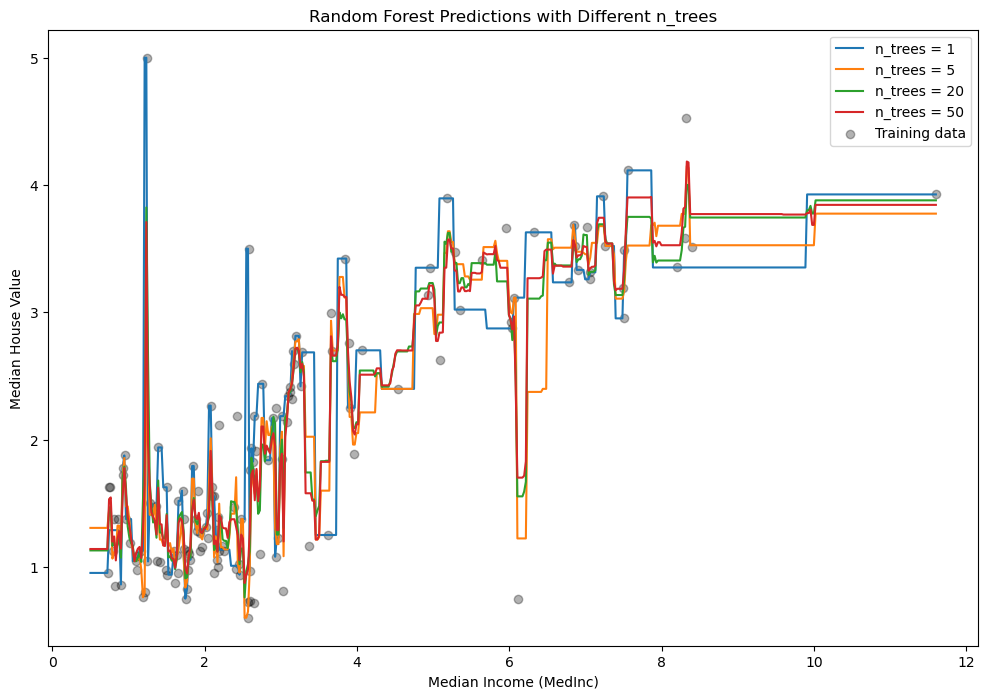

In [6]:
# Extract 'MedInc' as a 2D array
X_small_MedInc = housing_df['MedInc'].values[:n_samples_subset].reshape(-1, 1)
y_small_MedInc = housing_df['Target'].values[:n_samples_subset]

X_train, X_test, y_train, y_test = train_test_split(
    X_small_MedInc, y_small_MedInc, test_size=0.3, random_state=42)

# Define the range of 'MedInc' values for plotting
X_range = np.linspace(X_small_MedInc.min(), X_small_MedInc.max(), 500).reshape(-1, 1)

# List of n_trees to visualize
n_trees_list = [1, 5, 20, 50]

# Plotting
plt.figure(figsize=(12, 8))

for n_trees in n_trees_list:
    # Initialize the Random Forest model with adjusted hyperparameters
    rf = RandomForest(
        n_trees=n_trees,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=1
    )

    # Train the model without sample weights
    rf.fit(X_train, y_train, criterion='mse')

    # Predict over the range of 'MedInc' values
    y_pred_range = rf.predict(X_range)

    # Sort X_range and y_pred_range for plotting
    sorted_idx = np.argsort(X_range[:, 0])
    X_plot = X_range[sorted_idx]
    y_plot = y_pred_range[sorted_idx]

    # Plot the predictions
    plt.plot(X_plot, y_plot, label=f'n_trees = {n_trees}')

# Scatter plot of the training data
plt.scatter(X_train, y_train, color='black', alpha=0.3, label='Training data')

plt.xlabel('Median Income (MedInc)')
plt.ylabel('Median House Value')
plt.title('Random Forest Predictions with Different n_trees')
plt.legend()
plt.show()


## Training and Prediction with MSE

---



In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X_small, y_small, sample_weights, test_size=0.3, random_state=42)

Feature Importances: [0.25615098 0.07916171 0.14255807 0.07549486 0.07284658 0.13238424
 0.14780959 0.09359396]


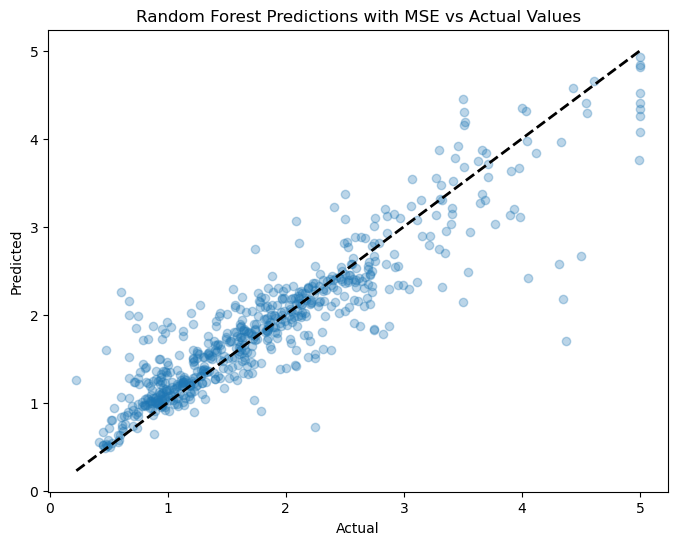

In [10]:
# Step 5: Test the Random Forest
# Initialize the random forest with custom parameters
# mse is the default error
# boostrap is default
rf = RandomForest(
    n_trees=20,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5, min_weight_fraction_leaf=0.01,
    max_features=4)

# Train the model
rf.fit(X_train, y_train, criterion='mse')

# Predict on the test set
y_pred = rf.predict(X_test)

# Step 4: Evaluate the model using Mean Squared Error

# Access feature importances
feature_importances = rf.feature_importances_
print("Feature Importances:", feature_importances)

# Plot predicted vs actual values for visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions with MSE vs Actual Values')
plt.show()

In [11]:
# Check for NaN values in y_test and y_pred
print(f'NaN in y_test: {np.isnan(y_test).sum()}')
print(f'NaN in y_pred: {np.isnan(y_pred).sum()}')

NaN in y_test: 0
NaN in y_pred: 0


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Remove NaN values from both y_test and y_pred
mask = ~np.isnan(y_test) & ~np.isnan(y_pred)  # Mask to filter out NaNs from both arrays
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Now calculate the metrics on the filtered data
mse = mean_squared_error(y_test_filtered, y_pred_filtered)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

r2 = r2_score(y_test_filtered, y_pred_filtered)
print(f'R² Score: {r2:.4f}')


Mean Squared Error (MSE): 0.1696
Root Mean Squared Error (RMSE): 0.4118
Mean Absolute Error (MAE): 0.2733
R² Score: 0.8155


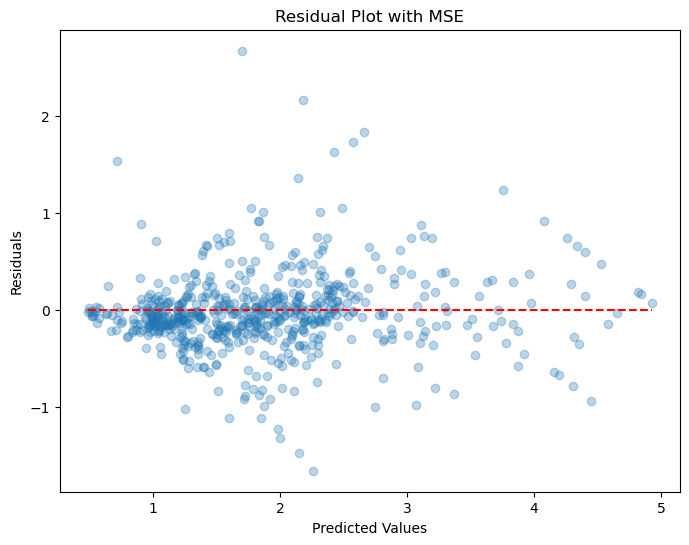

In [13]:
# Residuals: Difference between actual and predicted values
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot with MSE')
plt.show()


## Training and Prediction with MAE


Feature Importances: [0.21358631 0.07370089 0.1217343  0.09697199 0.07667072 0.14376572
 0.1519868  0.12158326]


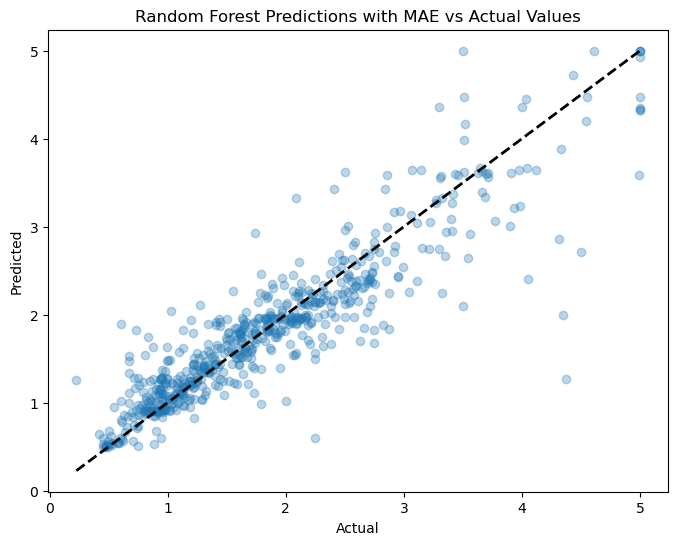

In [14]:
# Step 5: Test the Random Forest
# Initialize the random forest with custom parameters
# mse is the default error
# boostrap is default
rf = RandomForest(
    n_trees=20,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5, min_weight_fraction_leaf=0.01,
    max_features=4)

# Train the model
rf.fit(X_train, y_train, criterion='mae')

# Predict on the test set
y_pred = rf.predict(X_test)

# Step 4: Evaluate the model using Mean Squared Error

# Access feature importances
feature_importances = rf.feature_importances_
print("Feature Importances:", feature_importances)

# Plot predicted vs actual values for visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions with MAE vs Actual Values')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Remove NaN values from both y_test and y_pred
mask = ~np.isnan(y_test) & ~np.isnan(y_pred)  # Mask to filter out NaNs from both arrays
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Now calculate the metrics on the filtered data
mse = mean_squared_error(y_test_filtered, y_pred_filtered)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

r2 = r2_score(y_test_filtered, y_pred_filtered)
print(f'R² Score: {r2:.4f}')


Mean Squared Error (MSE): 0.1632
Root Mean Squared Error (RMSE): 0.4039
Mean Absolute Error (MAE): 0.2610
R² Score: 0.8225


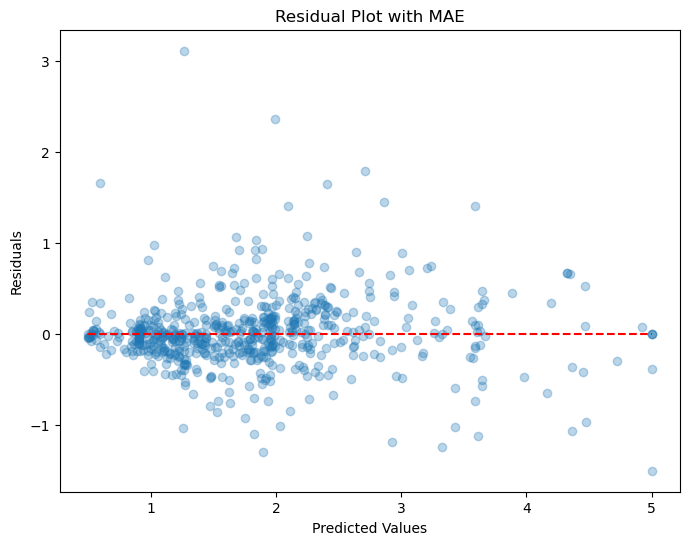

In [16]:
# Residuals: Difference between actual and predicted values
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot with MAE')
plt.show()


## Effect of n_trees (Number of Trees)



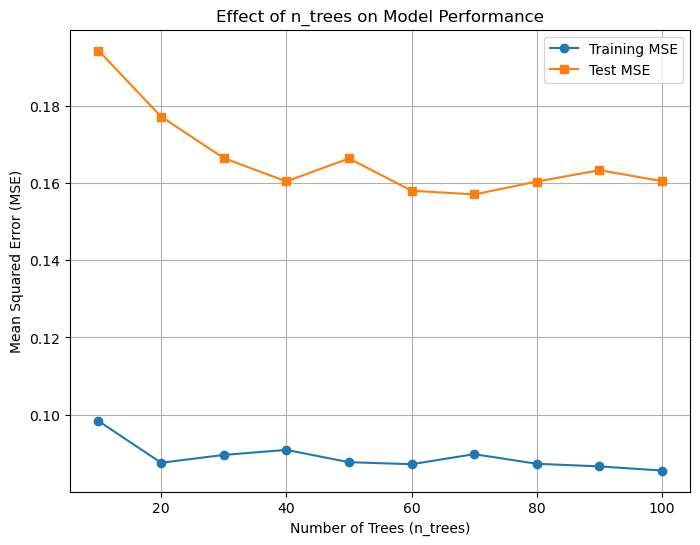

In [17]:
n_trees_values = range(10, 110, 10)
train_mse_values = []
test_mse_values = []

for n_trees in n_trees_values:
    rf = RandomForest(
        n_trees=n_trees,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.01,
        max_features=4
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(n_trees_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(n_trees_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of n_trees on Model Performance')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()



## Effect of max_depth (Maximum Depth of Trees)

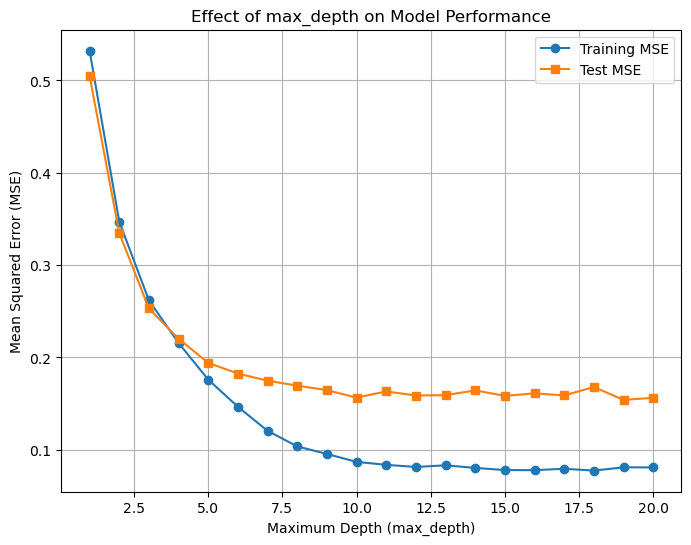

In [18]:
max_depth_values = range(1, 21)
train_mse_values = []
test_mse_values = []

for max_depth in max_depth_values:
    rf = RandomForest(
        n_trees=50,
        max_depth=max_depth,
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.01,
        max_features=4
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(max_depth_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(max_depth_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of max_depth on Model Performance')
plt.xlabel('Maximum Depth (max_depth)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


## Effect of min_samples_split (Minimum Samples to Split an Internal Node)

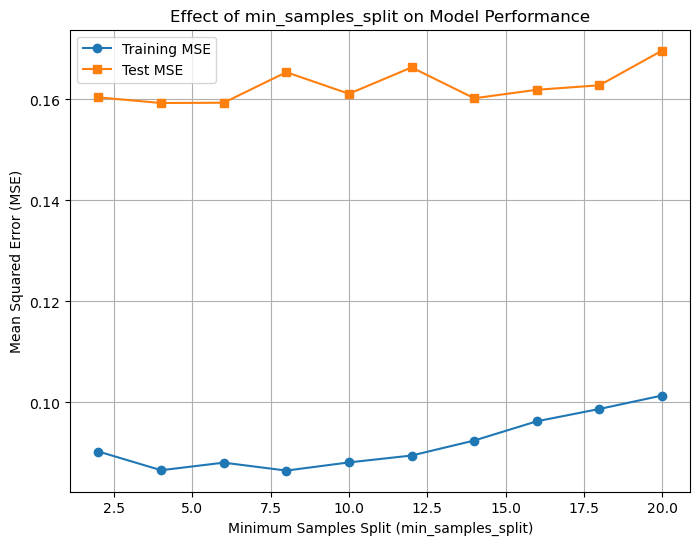

In [19]:
min_samples_split_values = range(2, 21, 2)
train_mse_values = []
test_mse_values = []

for min_samples_split in min_samples_split_values:
    rf = RandomForest(
        n_trees=50,
        max_depth=10,
        min_samples_split=min_samples_split,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.01,
        max_features=4
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(min_samples_split_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(min_samples_split_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of min_samples_split on Model Performance')
plt.xlabel('Minimum Samples Split (min_samples_split)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()



## Effect of min_samples_leaf (Minimum Samples at a Leaf Node)



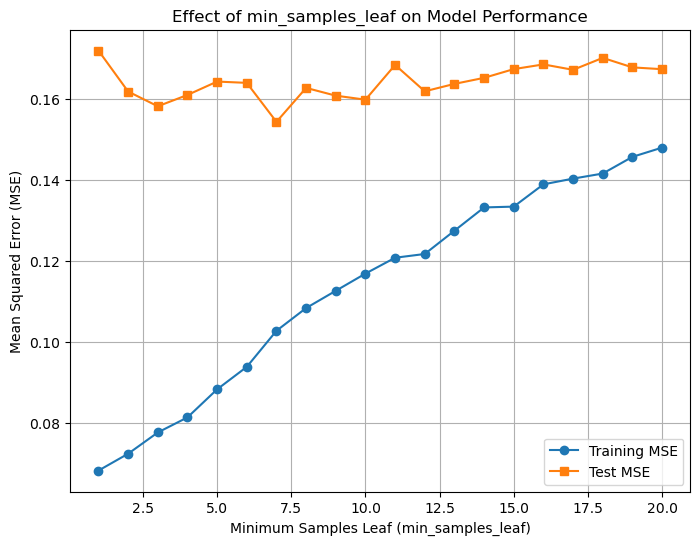

In [20]:
min_samples_leaf_values = range(1, 21)
train_mse_values = []
test_mse_values = []

for min_samples_leaf in min_samples_leaf_values:
    rf = RandomForest(
        n_trees=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=0.01,
        max_features=4
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(min_samples_leaf_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(min_samples_leaf_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of min_samples_leaf on Model Performance')
plt.xlabel('Minimum Samples Leaf (min_samples_leaf)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


Effect of min_weight_fraction_leaf (Minimum Weighted Fraction of the Input Samples at a Leaf Node)

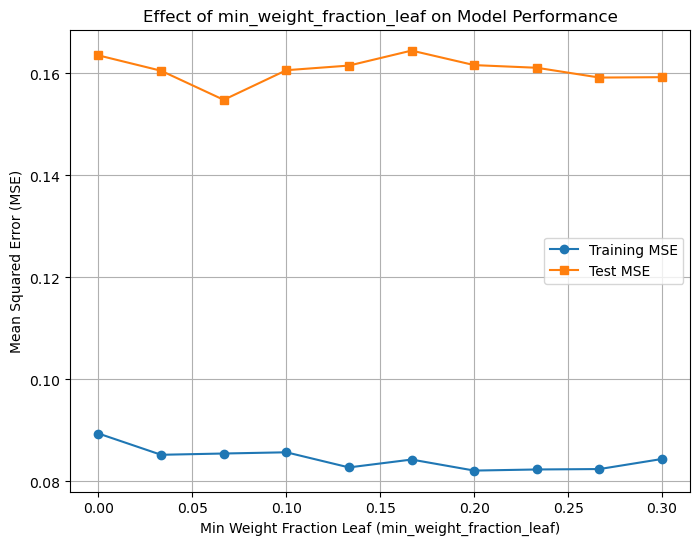

In [21]:
min_weight_fraction_leaf_values = np.linspace(0.0, 0.3, 10)
train_mse_values = []
test_mse_values = []

for min_weight_fraction_leaf in min_weight_fraction_leaf_values:
    rf = RandomForest(
        n_trees=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=4
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(min_weight_fraction_leaf_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(min_weight_fraction_leaf_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of min_weight_fraction_leaf on Model Performance')
plt.xlabel('Min Weight Fraction Leaf (min_weight_fraction_leaf)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()



## Effect of max_features (Number of Features to Consider When Looking for the Best Split)

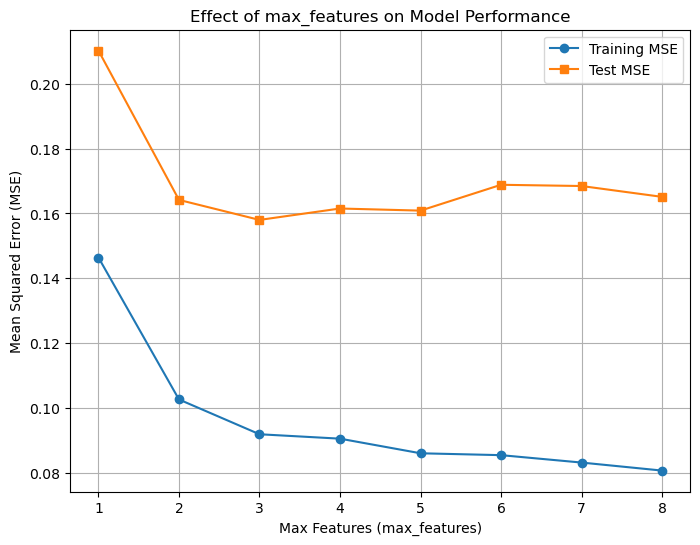

In [22]:
n_features = X_train.shape[1]
max_features_values = range(1, n_features + 1)
train_mse_values = []
test_mse_values = []

for max_features in max_features_values:
    rf = RandomForest(
        n_trees=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.01,
        max_features=max_features
    )
    rf.fit(X_train, y_train, criterion='mse')
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)

plt.figure(figsize=(8, 6))
plt.plot(max_features_values, train_mse_values, marker='o', label='Training MSE')
plt.plot(max_features_values, test_mse_values, marker='s', label='Test MSE')
plt.title('Effect of max_features on Model Performance')
plt.xlabel('Max Features (max_features)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()



## Feature Importances

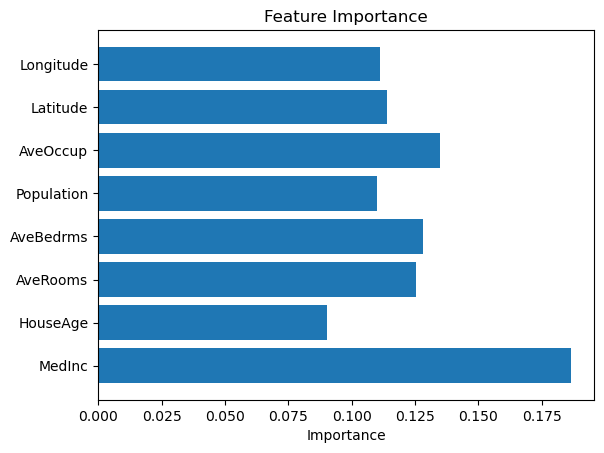

In [23]:
rf = RandomForest(n_trees=50, max_depth=10, max_features=4)
rf.fit(X_train, y_train, criterion='mse')

# Plot Feature Importance
feature_importances = rf.feature_importances_
features = housing_df.drop(['Target'], axis=1).columns
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


## Compare Models with and without Bootstrapping

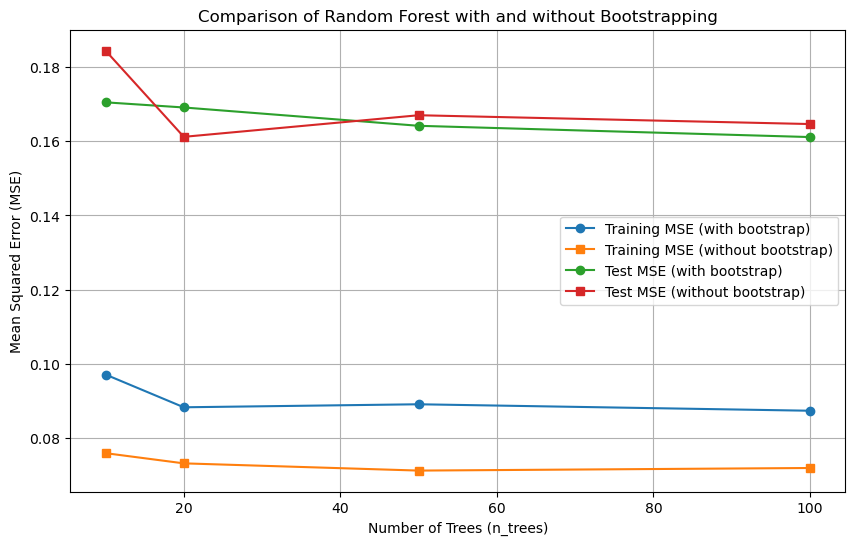

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Train and evaluate a model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, n_trees=50, bootstrap=True):
    rf = RandomForest(
        n_trees=n_trees,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.01,
        max_features=4,
        bootstrap=bootstrap
    )

    # Train the model
    rf.fit(X_train, y_train, criterion='mse')

    # Predict on the training set
    y_train_pred = rf.predict(X_train)

    # Predict on the test set
    y_test_pred = rf.predict(X_test)

    # Calculate training and testing MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return train_mse, test_mse

# Load the data and split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# Store MSE results for plotting
train_mse_with_bootstrap = []
test_mse_with_bootstrap = []

train_mse_without_bootstrap = []
test_mse_without_bootstrap = []

# Set number of trees to evaluate
n_trees_list = [10, 20, 50, 100]

for n_trees in n_trees_list:
    # With bootstrapping
    train_mse, test_mse = train_and_evaluate_model(X_train, X_test, y_train, y_test, n_trees=n_trees, bootstrap=True)
    train_mse_with_bootstrap.append(train_mse)
    test_mse_with_bootstrap.append(test_mse)

    # Without bootstrapping
    train_mse, test_mse = train_and_evaluate_model(X_train, X_test, y_train, y_test, n_trees=n_trees, bootstrap=False)
    train_mse_without_bootstrap.append(train_mse)
    test_mse_without_bootstrap.append(test_mse)

# Plotting
plt.figure(figsize=(10, 6))

# Training MSE
plt.plot(n_trees_list, train_mse_with_bootstrap, label='Training MSE (with bootstrap)', marker='o')
plt.plot(n_trees_list, train_mse_without_bootstrap, label='Training MSE (without bootstrap)', marker='s')

# Testing MSE
plt.plot(n_trees_list, test_mse_with_bootstrap, label='Test MSE (with bootstrap)', marker='o')
plt.plot(n_trees_list, test_mse_without_bootstrap, label='Test MSE (without bootstrap)', marker='s')

plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Random Forest with and without Bootstrapping')
plt.legend()
plt.grid(True)
plt.show()


## Comparing model with loss function MSE and MAE

In [25]:
# Initialize Random Forest with MSE
rf_mse = RandomForest(
    n_trees=20,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.01,
    max_features=4,
    bootstrap=True  # You can toggle this as needed
)

# Train the model using MSE
rf_mse.fit(X_train, y_train, criterion='mse')

# Initialize Random Forest with MAE
rf_mae = RandomForest(
    n_trees=20,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.01,
    max_features=4,
    bootstrap=True  # Same bootstrap setting for fair comparison
)

# Train the model using MAE
rf_mae.fit(X_train, y_train, criterion='mae')


In [26]:
# Predictions with MSE
y_train_pred_mse = rf_mse.predict(X_train)
y_test_pred_mse = rf_mse.predict(X_test)

# Predictions with MAE
y_train_pred_mae = rf_mae.predict(X_train)
y_test_pred_mae = rf_mae.predict(X_test)

# Calculate Metrics
metrics = {
    'Model': ['Random Forest (MSE)', 'Random Forest (MAE)'],
    'Train MSE': [
        mean_squared_error(y_train, y_train_pred_mse),
        mean_squared_error(y_train, y_train_pred_mae)
    ],
    'Test MSE': [
        mean_squared_error(y_test, y_test_pred_mse),
        mean_squared_error(y_test, y_test_pred_mae)
    ],
    'Train MAE': [
        mean_absolute_error(y_train, y_train_pred_mse),
        mean_absolute_error(y_train, y_train_pred_mae)
    ],
    'Test MAE': [
        mean_absolute_error(y_test, y_test_pred_mse),
        mean_absolute_error(y_test, y_test_pred_mae)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                 Model  Train MSE  Test MSE  Train MAE  Test MAE
0  Random Forest (MSE)   0.089425  0.170373   0.188613  0.275241
1  Random Forest (MAE)   0.114334  0.161778   0.162096  0.257011


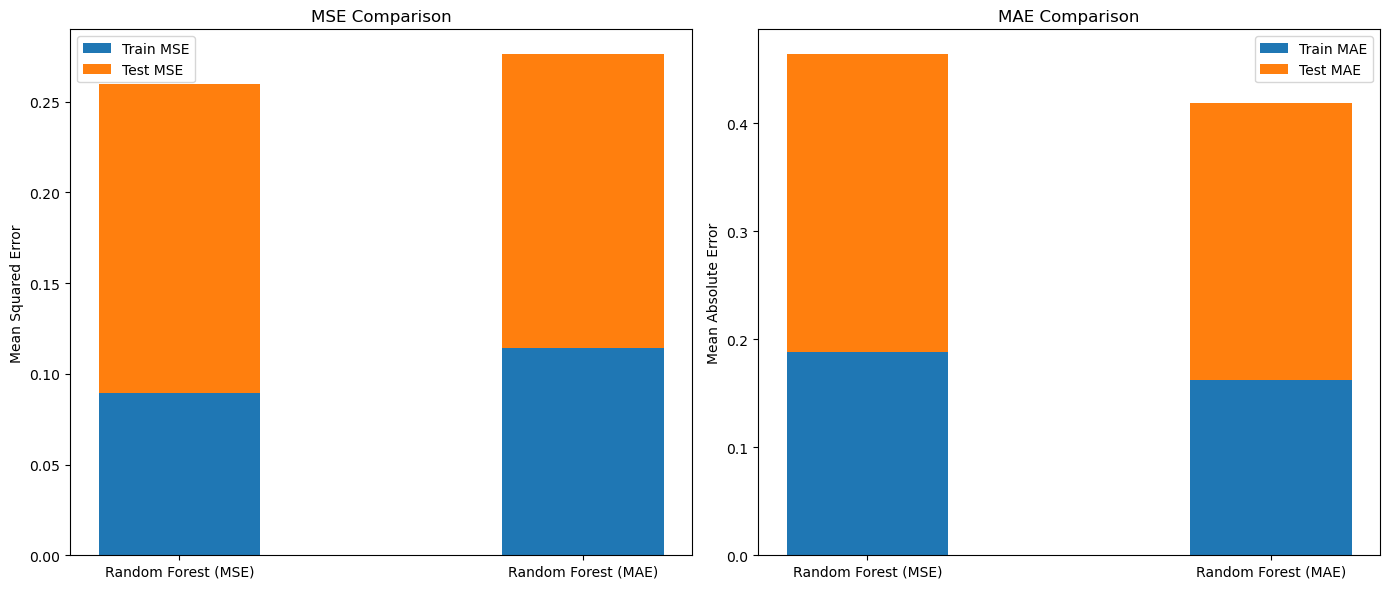

In [27]:
# Plot MSE and MAE for Training and Testing
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE Comparison
axes[0].bar(metrics_df['Model'], metrics_df['Train MSE'], width=0.4, label='Train MSE')
axes[0].bar(metrics_df['Model'], metrics_df['Test MSE'], width=0.4, bottom=metrics_df['Train MSE'], label='Test MSE')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE Comparison')
axes[0].legend()

# MAE Comparison
axes[1].bar(metrics_df['Model'], metrics_df['Train MAE'], width=0.4, label='Train MAE')
axes[1].bar(metrics_df['Model'], metrics_df['Test MAE'], width=0.4, bottom=metrics_df['Train MAE'], label='Test MAE')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('MAE Comparison')
axes[1].legend()

plt.tight_layout()
plt.show()


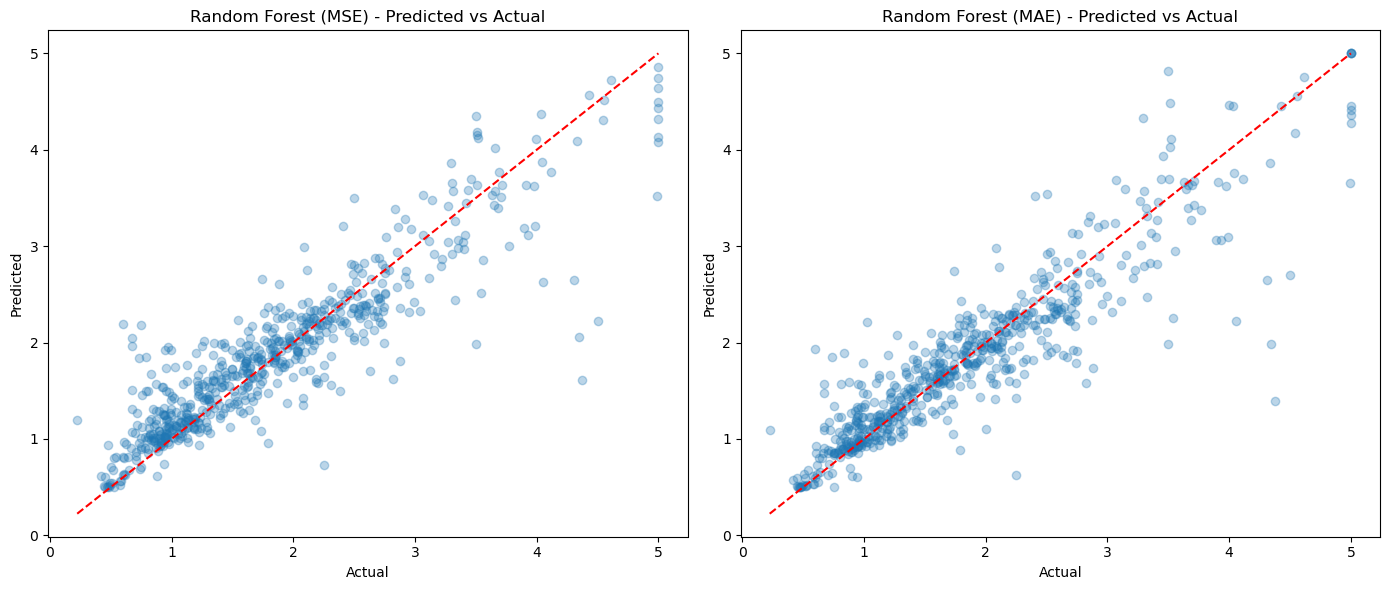

In [28]:
# Plot Predicted vs Actual for Test Set
plt.figure(figsize=(14, 6))

# Random Forest with MSE
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_mse, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest (MSE) - Predicted vs Actual')

# Random Forest with MAE
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_mae, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest (MAE) - Predicted vs Actual')

plt.tight_layout()
plt.show()
